<a href="https://colab.research.google.com/github/IqbalLx/Machine-Learning-Deep-Learning-Project/blob/master/Dicoding%20ML%20dev%20final%20submissions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Disclaimer
Remember to use this code as reference only, if you used this for your own Dicoding's beginner machine learning courses final submissions, your account may get permanent banned

# Preparing the Dataset

In [0]:
!wget --no-check-certificate \
  https://dicodingacademy.blob.core.windows.net/picodiploma/ml_pemula_academy/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

In [0]:
import os
import zipfile

filename = "/tmp/rockpaperscissors.zip"
ref = zipfile.ZipFile(filename)
ref.extractall()
ref.close()

In [0]:
print(len(os.listdir('rockpaperscissors/paper')))
print(len(os.listdir('rockpaperscissors/rock')))
print(len(os.listdir('rockpaperscissors/scissors')))

712
726
750


In [0]:
try:
  os.mkdir('training')
  os.mkdir('validation')

  os.mkdir('training/paper')
  os.mkdir('training/rock')
  os.mkdir('training/scissors')

  os.mkdir('validation/paper')
  os.mkdir('validation/rock')
  os.mkdir('validation/scissors')
except OSError as e:
  print(e)

In [0]:
import shutil
import random
import numpy as np
import matplotlib.image as image
import matplotlib.pyplot as plt

plt.style.use('seaborn')

In [0]:
def train_val_split(source, training, validation, size):
  list_data = os.listdir(source)
  length = len(list_data)

  randomized_list_data = random.sample(list_data, length)
  split_size = [int(size*length)]

  splitted_list_data = [randomized_list_data[i:j] for i, j in zip(
      [0] + split_size, split_size + [None]
  )]

  for training_data in splitted_list_data[0]:
    shutil.copyfile(source+training_data, training+training_data) 
  for validation_data in splitted_list_data[1]:
    shutil.copyfile(source+validation_data, validation+validation_data) 
  
  return print('200 OK')

In [0]:
#source dir
paper_dir = 'rockpaperscissors/paper/'
rock_dir = 'rockpaperscissors/rock/'
scissors_dir = 'rockpaperscissors/scissors/'

#training_dir
paper_training_dir = 'training/paper/'
rock_training_dir = 'training/rock/'
scissors_training_dir = 'training/scissors/'

#validation dir
paper_validation_dir = 'validation/paper/'
rock_validation_dir = 'validation/rock/'
scissors_validation_dir = 'validation/scissors/'

#splitting
split_size = 0.9
train_val_split(paper_dir, paper_training_dir, paper_validation_dir, split_size)
train_val_split(rock_dir, rock_training_dir, rock_validation_dir, split_size)
train_val_split(scissors_dir, scissors_training_dir, scissors_validation_dir, split_size)

200 OK
200 OK
200 OK


In [0]:
#check size
def check_size(source, type):
  global split_size
  before_split = len(os.listdir(source))
  train_after_split = len(os.listdir(f'training/{type}'))
  train_after_split_size = int(before_split*split_size)
  if train_after_split_size == train_after_split:
    return print(f'{type} spliting OK')
  else:
    print(f'obtained size {train_after_split}, expected {train_after_split_size}')
    return print(f'{type} spliting Error')

check_size(paper_dir, 'paper')
check_size(rock_dir, 'rock')
check_size(scissors_dir, 'scissors')

paper spliting OK
rock spliting OK
scissors spliting OK


#Overview dataset

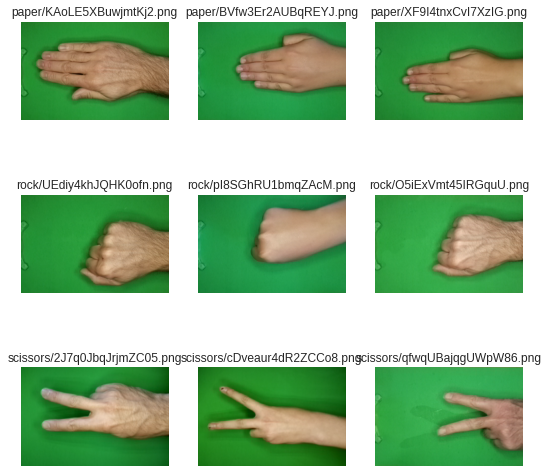

In [0]:
plt.figure(figsize=(9, 9))

index = np.random.randint(500)

list_paper = [os.path.join(paper_training_dir, name) for name in os.listdir(paper_training_dir)[index:index+3]]
list_rock = [os.path.join(rock_training_dir, name) for name in os.listdir(rock_training_dir)[index:index+3]]
list_scissors = [os.path.join(scissors_training_dir, name) for name in os.listdir(scissors_training_dir)[index:index+3]]

for i, path in enumerate(list_paper+list_rock+list_scissors):
  plt.subplot(3, 3, i+1)
  plt.axis('off')

  plt.title(path.replace('training/', ''))
  img = image.imread(path)
  plt.imshow(img)

The variety of training dataset is pretty good, there is image in the center of the frame, also in the corner of the frame. But all image is from right side, we can add the variety of angle by flipping and rotating in Image Data Generator.

#Building Generator

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

In [0]:
training_image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=270,
                                                                         horizontal_flip=True,
                                                                         zoom_range=0.2,
                                                                         shear_range=0.2,
                                                                         width_shift_range=0.2,
                                                                         height_shift_range=0.2,
                                                                         fill_mode='nearest',
                                                                         rescale=1/255)

#I want validation to be real images, so I am not augmented it
validation_image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_generator = training_image_datagen.flow_from_directory(
    'training',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_generator = validation_image_datagen.flow_from_directory(
    'validation',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 1968 images belonging to 3 classes.
Found 220 images belonging to 3 classes.


#Build Model

In [0]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
                                    tf.keras.layers.MaxPool2D(2, 2),
                                    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                                    tf.keras.layers.MaxPool2D(2, 2),
                                    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
                                    tf.keras.layers.MaxPool2D(2, 2),
                                    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
                                    tf.keras.layers.MaxPool2D(2, 2),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(512, activation='relu'),
                                    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='RMSProp',
    metrics=['accuracy']
)

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [0]:
#Early stop if accuracy already more than 95% and didnt significantly increased after that
class early_stop(tf.keras.callbacks.Callback):
  def __init__(self, threshold=0.95, patience=3, significance_val=0.001):
    super(early_stop, self).__init__()

    self.threshold = threshold                #Minimum accuracy
    self.patience = patience                  #Limit epoch to wait if accuracy no longer increased
    self.significance_val = significance_val  #Significant value to mark improvement in accuracy
    self.best_weights = None                  #Best weights record

  def on_train_begin(self, logs=None):
    self.previous_acc = 0                     #Track previous accuracy
    self.wait = 0                             #Track epoch when accuracy no longer increased

  def on_epoch_end(self, epoch, logs={}):
    self.current_acc = logs.get('accuracy')   #Current epoch's accuracy
    if self.current_acc > self.threshold:
      if self.current_acc - self.previous_acc > self.significance_val:
        self.wait = 0
        self.previous_acc = self.current_acc
        self.best_weights = self.model.get_weights()
      else:
        self.wait += 1
        if self.wait >= self.patience:
          self.model.stop_training = True
          print(f'\n[INFO] Accuracy didnt increased after 3 epochs, training stopped...')
          self.model.set_weights(self.best_weights)
          print(f'\n[INFO] Restoring best weights from best accuracy epoch')

In [0]:
hist = model.fit(
    train_generator,
    steps_per_epoch=int(1968/32), # 1968 images = batch_size (32) * steps
    epochs=100,
    validation_data=val_generator,
    validation_steps=int(220/32), # 220 images = batch_size (32) * steps
    callbacks=[early_stop()],
    verbose=1
)

Epoch 1/100
61/61 [==============================] - 14s 229ms/step - loss: 1.1434 - accuracy: 0.3636 - val_loss: 1.0522 - val_accuracy: 0.3594
Epoch 2/100
61/61 [==============================] - 14s 229ms/step - loss: 1.0827 - accuracy: 0.4396 - val_loss: 0.9016 - val_accuracy: 0.6979
Epoch 3/100
61/61 [==============================] - 14s 225ms/step - loss: 0.9590 - accuracy: 0.5832 - val_loss: 0.5191 - val_accuracy: 0.7760
Epoch 4/100
61/61 [==============================] - 14s 229ms/step - loss: 0.7895 - accuracy: 0.6622 - val_loss: 0.6398 - val_accuracy: 0.7500
Epoch 5/100
61/61 [==============================] - 14s 230ms/step - loss: 0.6631 - accuracy: 0.7092 - val_loss: 0.5338 - val_accuracy: 0.8073
Epoch 6/100
61/61 [==============================] - 14s 229ms/step - loss: 0.5662 - accuracy: 0.7758 - val_loss: 0.2440 - val_accuracy: 0.9062
Epoch 7/100
61/61 [==============================] - 14s 228ms/step - loss: 0.3860 - accuracy: 0.8549 - val_loss: 0.1784 - val_accuracy:

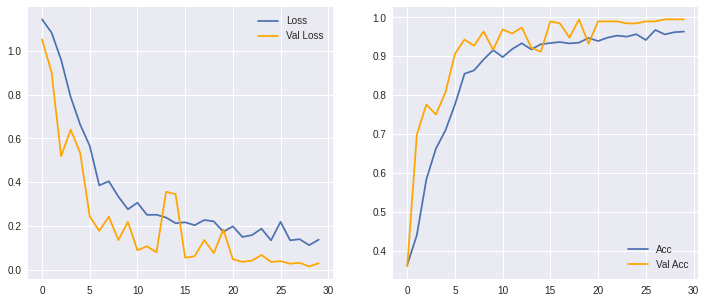

In [0]:
history = hist.history
history['epoch'] = hist.epoch

plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.plot(history['epoch'], history['loss'], label='Loss')
plt.plot(history['epoch'], history['val_loss'], label='Val Loss', color='orange')
plt.legend()

plt.subplot(122)
plt.plot(history['epoch'], history['accuracy'], label='Acc')
plt.plot(history['epoch'], history['val_accuracy'], label='Val Acc', color='orange')
plt.legend()

plt.show()

Saving testrock04-14.png to testrock04-14.png
testrock04-14.png
[[0. 1. 0.]]
rock


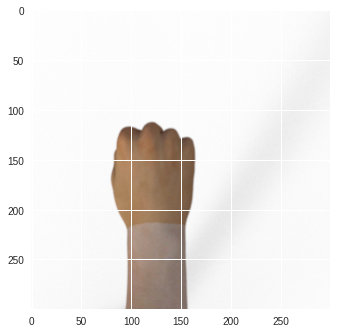

In [0]:
from google.colab import files
from keras.preprocessing import image as img

class_name = ['paper','rock','scissors']
filenames = files.upload()
for filename in filenames.keys():
  #Predict classes
  pict = img.load_img(filename, target_size=(150, 150))
  x = img.img_to_array(pict)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(filename)
  print(classes)
  print(class_name[np.argmax(classes)])

  #show img
  show_img = image.imread(filename)
  plt.imshow(show_img)